# Support Vector Machine for binary classification

In this notebook, we describe theoretical background of Support Vector Machine (SVM) classification, and implement it.

Although some calculations are shown in the textbook, the discussion there (especially the treatment of primal-dual correspondence and the way of obtaining the threshold $b$) is insufficient. So, I will describe some aspects in detail.

Note : Here we assume finite dimensional feature space. However, note that widely utilized kernels such as Gaussian kernel induces infinite-dimensional feature space. Thus, the derivation shown in the notebook (and the textbook) does not apply to SVM with Gaussian kernel. 

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

np.random.seed(42)

# 1 Setting 

We consider binary classification problem.

* $N \in \mathbb{N}$ : data size,
* $X$ : set of all possible inputs
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in X$. 
* Denote target data by $t_0, t_1, \dots, t_{N-1} \in \{ -1, 1 \}$.


# 2 Theoretical background 

Here we first discuss theoretical background of SVM classifier. 
The notation follows that of the textbook, unless otherwise stated. 

For those who are not interested in theoretical background, please skip the section, and go to Section 3. 


## 2.1 Original minimizatoin problem 

Following the discussion in the textbook, our task here is to solve the following minimization problem
$$
\begin{align}
    & \min_{w\in \mathbb{R}^M, \\ b \in \mathbb{R}, \xi \in \mathbb{R}^N} \left( C \sum_{n=0}^{N-1} \xi_n + \frac{1}{2} \| w \|^2 \right) \\
    & \xi_n \geq 0  \ \ (\forall n \in \{ 0, 1, \dots, N-1 \}),\\ 
    & t_n \left[ w^T \phi(x_n) + b \right] \geq 1 - \xi_n \ \ (\forall n \in \{ 0, 1, \dots, N-1 \}),
\end{align}
$$
where $C>0$ is a constant, $M \in \mathbb{R}$ is the dimension of the feature space, and $\phi : X \rightarrow \mathbb{R}^M$ is a mapping from input to features. 
We assume that the kernel function $k : X \times X \rightarrow \mathbb{R}$ defined by $k(x, x') = \phi(x)^T \phi(x')$ is positive definite.

It can be proved mathematically rigorously that the problem has a minimum solution.

For later convenience, we will denote
$$
\begin{align}
    x &:= (w, b, \xi) \in \mathbb{R}^M \times \mathbb{R} \times \mathbb{R}^N = \mathbb{R}^{N+M+1} \\
    f(x) &:= C \sum_{n=0}^{N-1} \xi_n + \frac{1}{2} \| w \|^2 \\
    g_n(x) &:= t_n \left[ w^T \phi(x_n) + b \right] - 1 + \xi_n \\
    h_n(x) &:= \xi_n
\end{align}
$$
and 
$$
\begin{align}
    S := \left\{ x \in \mathbb{R}^{N+M+1} \middle | 
        g_n(x) \geq 0, h_n(x) \geq 0 \ (\forall n \in \{0, \dots, N-1 \}) \right\}
\end{align}
$$

Note that 
* the objective functoin $f$ is a convex function, 
* the functions representing constraints $g_n$ and $h_n$ are affine functions, and 
* $S$ is a convex set, and has interior points.

We solve this minimization problem by utilizing Lagrangian duality. 

Before considering our specific problem, in the next section we will discuss Lagrangian duality from more general perspectives, and come back to our SVM problem in the following section.

## 2.2 Lagrange duality (general theory)


### 2.2.1 Lagrangian 

Let us consider a general optimization problem of minimizing $f : \mathbb{R}^n \rightarrow \mathbb{R}$ under the constraints represnted by $g_i : \mathbb{R}^n \rightarrow \mathbb{R}$, $g_i(x) \geq 0$ $(i \in \{ 0, \dots, m-1 \})$. 
For simplicity, we denote by $S$ the region satisfying the constraints.

Inspired by the Lagrange multiplier method, let us define the Lagrangian $L : \mathbb{R}^n \times \mathbb{R}_{+}^{m} \rightarrow \mathbb{R}$ by
$$
\begin{align}
    L(x,\lambda) = f(x) - \sum_{i=0}^{m-1} \lambda_i g_i(x), 
\end{align}
$$
where $\mathbb{R}_{+}$ denotes the set of all non-negative real numbers.

The idea here is to convert the minimization problem with respect to $x$ to a maximization problem with respect to $\lambda$. 

### 2.2.2 Dual problem

Let us define two functions from the Lagrangian as follows
$$
\begin{align}
    F(x) &:= \sup_{\lambda \in \mathbb{R}_{+}^{m}} L(x,\lambda) \\
    q(\lambda) &:= \inf_{x \in \mathbb{R}^n} L(x, \lambda) . 
\end{align}
$$

Note that 
$$
\begin{align}
    F(x) = \sup_{\lambda \in \mathbb{R}_{+}^{m}} L(x,\lambda) =
    \begin{cases}
        f(x) & (\forall i \in \{ 0, \dots, m-1 \} (g_i(x) \geq 0 )) \\
        \infty & (\mbox{otherwise})
    \end{cases}, 
\end{align}
$$
and thus, we have 
$$
\begin{align}
    \inf_{x \in \mathbb{R}^n} F(x) = \inf_{x \in S} f(x)
\end{align}
$$

It follows easily from the definition that  
$$
\begin{align}
    &{} \forall x \in \mathbb{R}^n, \forall \lambda \in \mathbb{R}_{+}^{m} \ : \ 
        F(x) \geq L(x,\lambda) \geq q(\lambda) \\
    &{} \inf_{x \in S} f(x) \geq \sup_{\lambda \in \mathbb{R}_{+}^{m}} q(\lambda)
\end{align}
$$

Our expectation is that we can get some information about the original problem of minimizing $f$ in $S$ by solving the problem of maximising $q$ in $\mathbb{R}_{+}^{m}$. 
We call the latter problem the Lagrangian dual of the original problem. The original problem is also called the primal problem, in light of the dual problem.  


### 2.2.3 The relation between primal and dual problems

The expectation stated above is, under some conditions, correct: 
Assume the following conditions 
* $f$ is a convex function, and $g_i$ are all concave functions (Hence, the minimization problem is a convex optimizatoin problem).
* The set $S$ has at least one interior point (Slater's condition).
* $f$ attains its minimum at $x^{\ast} \in S$ and $q$ attains its maximum in $\lambda^{\ast} \in \mathbb{R}_{+}^{m}$. 

Then, it is known that 
$$
\begin{align}
    f(x^{\ast}) = q(\lambda^{\ast})
\end{align}
$$
follows (The (strong) duality theorem for convex optimization problem.).

Thus, we can obtain the minimum value of $f$ on $S$ by solving the dual problem. 
Moreover, we can obtain conditions on $x$ which maximizes $f$ on $S$:
* $ f(x^{\ast}) = L(x^{\ast}, \lambda^{\ast}) = q(\lambda^{\ast})$
* $\forall x \in \mathbb{R}^{n} \forall \lambda \in \mathbb{R}_{+}^{m} : L(x, \lambda^{\ast}) \geq L(x^{\ast}, \lambda^{\ast}) \geq L(x^{\ast}, \lambda)$

The former follows directly from the strong duality theorem, and the latter can be derived as $L(x, \lambda^{\ast}) \geq q(\lambda^{\ast}) = L(x^{\ast},\lambda^{\ast})$ and $L(x^{\ast}, \lambda) \leq F(x^{\ast}) = L(x^{\ast},  \lambda^{\ast})$.

## 2.3 Solving SVM optimizatoin problem by Lagrange duality

### 2.3.1 Lagrangian

We can directly apply the discussoin in the previous section to our SVM minimization problem, because

* as was stated, $f$ attains its minimum on $S$, 
* $S$ is a convex set which has an interior point.

Let us define our Lagrangian $L : \mathbb{R}^{N+M+1} \times \mathbb{R}_{+}^{2N} \rightarrow \mathbb{R}$ by 
$$
\begin{align}
    L(x,\lambda) := f(x) - \sum_{n=0}^{N-1} a_n g_n(x) - \sum_{n=0}^{N-1} \mu_n h_n(x),
\end{align}
$$
where $\lambda = (a,\mu)$, and $a,\mu \in \mathbb{R}^{N}_{+}$. 


### 2.3.2 The dual problem

Then, to evaluate $q(\lambda)$, which is obtained by minimizing $L(x,\lambda)$ with respect to $x$, we collect the terms in $L$ as follows: 
$$
\begin{align}
    L(x, \lambda) 
    &=  C \sum_{n=0}^{N-1} {\xi}_{n} 
        {} + \frac{1}{2} \| w \|^2 
        {} - \sum_{n=0}^{N-1} a_n \left[ t_n (w^T \phi(x_n) + b) - 1 + {\xi}_{n} \right] 
        {} - \sum_{n=0}^{N-1} \mu_n {\xi}_{n} \\
    &= \sum_{n=0}^{N-1}(C - \mu_n - a_n ) {\xi}_{n} 
        {} + \frac{1}{2} \| w \|^2 - \left[ \sum_{n=0}^{N-1} a_n t_n \phi(x_n) \right]^T w
        {} - \sum_{n=0}^{N-1} a_n( b t_n - 1)
\end{align}
$$

Hence, it can be easily shown that 
$$
\begin{align}
    q(\lambda) = \inf_{x\in\mathbb{R}^{N+M+1}} L(x,\lambda)
    = \begin{cases}
        \sum_{n=0}^{N-1} a_n - \frac{1}{2} \sum_{n,m=0}^{N-1} a_n a_m t_n t_m k(x_n, x_m)
        & (C - \mu_n - a_n = 0 (\forall n \in \{0,\dots, N-1 \}), \sum_{n=0}^{N-1} a_n t_n = 0) \\
        -\infty  & (\mbox{otherwise})
    \end{cases},
\end{align}
$$
where $k(x, x') := \phi(x)^T \phi(x')$. 

It can be shown that $q$ attains its maximum at $\lambda^{\ast} = (a^{\ast}, \mu^{\ast})$, $a^{\ast} \in [0, C]^{N}$, $\mu^{\ast}_{n} = C - a^{\ast}_{n}$. Note that $a^{\ast}$ satisfies $\sum_{n=0}^{N-1} a^{\ast}_{n} t_n = 0$.
Here we temporarily assume that $a^{\ast}$ is obtained, and proceed to the next section. 
We will discuss later in Section 2.5 how to numerically obtaining $a^{\ast}$. 

For later convenience, we define 
$$
\begin{align}
    \tilde{q}(a) &:= \sum_{n=0}^{N-1} a_n - \frac{1}{2} \sum_{n,m=0}^{N-1} a_n a_m t_n t_m k(x_n, x_m), \\
    S' &:= \left\{ a \in \mathbb{R}^N \middle| 0 \leq a_n \leq C \ (\forall n = 0, \dots, N-1), \ 
        \sum_{n=0}^{N-1} a_n t_n = 0 \right\}. 
\end{align}
$$


### 2.3.3 Determining the minimizer of the original problem

Here we discuss how the solution to the primal proble $x^{\ast} :=(w^{\ast}, b^{\ast}, \xi^{\ast}) $ can be determined from the solution of the dual problem.

#### 2.3.3.1 Determining $\xi$

Assuming $w^{\ast}$ and $b^{\ast}$ has been obtained, it can be easily shown that 
$$
\begin{align}
    \xi^{\ast}_{n} = \max \left\{  0, 1 - t_n[{w^{\ast}}^T \phi(x_n) + b^{\ast}] \right\}
\end{align}
$$


#### 2.3.3.2 Determining $w$

From the general result in the previous section, $x^{\ast}$ must satisfies 
$$
\begin{align}
    \forall x \in S : L(x^{\ast}, \lambda^{\ast}) \leq  L(x, \lambda^{\ast}), 
\end{align}
$$
i.e., $x^{\ast}$ minimizes $L(\cdot, \lambda^{\ast})$.
From this condition and definition of the Lagrangian, we have 
$$
\begin{align}
    w^{\ast} = \sum_{n=0}^{N-1} a^{\ast}_n t_n \phi(x_n)
\end{align}
$$
(Note that here $L(x, \lambda^{\ast})$ does not depend on $\xi$ and $b$.)

#### 2.3.3.3 Determining $b$

Note : It is stated in the textbook that we can obtain $b^{\ast}$ from equation (7.36) with $n$ satisfying $0 < a^{\ast}_{n} < C$. However, such $n$ does not always exist. A counter example can be easily constructed in which we have $a^{\ast}_{n} = C$ for all $n$ (e.g. $N=2$, $X=\mathbb{R}^2$, $x_0 = (1,0)^T, x_1 =(0,1)^T$, $t_0=1, t_1 = -1$, $k(x,x')=x^T x'$, $C=1/2$). Thus, here we present more general method from 
* Bottou, Lin "Support Vector Machine Solvers"
https://www.csie.ntu.edu.tw/~cjlin/papers/bottou_lin.pdf
* Chang, Lin "LIBSVM: A Library for Support Vector Machines" https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf



From the general result on Lagrange duality, it suffices to find $b^{\ast}$ such that $f(w^{\ast}, b^{\ast}, \xi^{\ast}) = \tilde{q}(a^{\ast})$.

We can write the difference between these two values by 
$$
\begin{align}
    f(w^{\ast}, b^{\ast}, \xi^{\ast}) - \tilde{q}(a^{\ast})
    = \sum_{n=0}^{N-1}\left[ C \max \{ 0, g_n(a^{\ast}) - b^{\ast} t_n \} - a^{\ast}_{n} g_n(a^{\ast}) \right]
\end{align}
$$
where
$$
\begin{align}
    g_n(a) := \frac{\partial \tilde{q}}{\partial a_n} = 1 - t_n \sum_{m=0}^{N-1} a_m t_m k(x_n, x_m).
\end{align}
$$

$b^{\ast}$ can be any values that satisfies the above equality. Here we describe a method of obtaining a concrete value of $b$.

Let us define $C_n := C \max \{ 0, g_n(a^{\ast}) - b t_n \} - a^{\ast}_{n} g_n(a^{\ast})$. 
Then, our task here is to find $b$ such that $\sum_{n=0}^{N-1} C_n = 0$.

Observing that 
$$
\begin{align}
    & g_n(a^{\ast}) > bt_n \Longrightarrow C_n = (C- a^{\ast}_n) g_n(a^{\ast}) - b C t_n \\
    & g_n(a^{\ast}) < bt_n \Longrightarrow C_n = - a^{\ast}_n g_n(a^{\ast}) \\
    & g_n(a^{\ast}) = bt_n \Longrightarrow C_n = - a^{\ast}_n g_n(a^{\ast}) = - b a^{\ast}_n t_n, 
\end{align}
$$
we try to find $b$ such that $C_n = - b a^{\ast}_n t_n$, because if it holds, we have $\sum_{n=0}^{N-1} C_n =- b\sum_{n=0}^{N-1}a^{\ast}_n t_n = 0 $.

For that aim, it suffices to find $b$ such that 
$$
\begin{align}
    g_n(a^{\ast}) > b t_n \Longrightarrow a^{\ast}_{n} = C \\
    g_n(a^{\ast}) < b t_n \Longrightarrow a^{\ast}_{n} = 0 
\end{align}
$$
It can be shown that such $b$ exists, using the fact that $a^{\ast}$ maximizes $\tilde{q}$ on $S'$, and hence satisfies the corresponding KKT condition.

We can write the above condition as
$$
\begin{align}
    n \in I_{up}(a^{\ast}) \Longrightarrow b \geq t_n g_n(a^{\ast})  \\
    n \in I_{low}(a^{\ast}) \Longrightarrow b \leq t_n g_n(a^{\ast}) 
\end{align}
$$
where
$$
\begin{align}
    I_{up}(a) &:= \left\{n \in \left\{ 0, 1, \dots, N-1 \right\} 
        \middle| (a_n < C \mbox{ and } t_n = 1) \mbox{ or } (a_n > 0 \mbox{ and } t_n = -1) \right\} \\
    I_{low}(a) &:= \left\{n \in \left\{ 0, 1, \dots, N-1 \right\} 
        \middle| (a_n < C \mbox{ and } t_n = -1)  \mbox{ or } (a_n > 0 \mbox{ and } t_n = 1)  \right\}
\end{align}
$$

Thus, $b$ can be any values such that 
$$
\begin{align}
    \max_{n \in I_{up}(a^{\ast})} t_n g_n(a^{\ast})  \leq b \leq \min_{n \in I_{low}(a^{\ast})} t_n g_n(a^{\ast}) 
\end{align}
$$


## 2.4 Prediction

Having obtained parameter $w^{\ast}$ and $b^{\aset}$, we can make prediction for a input $x \in X$ as
$$
\begin{align}
    \mathrm{sign} \left[ {w^{\ast}}^T \phi(x) + b^{\ast}  \right]
    = \mathrm{sign} \left[ \sum_{n=0}^{N-1} a^{\ast}_{n} t_n k(x_n, x) + b^{\ast}  \right]
\end{align}
$$

We can see that $x_n$ with $n$ such that $a_n = 0$ does not appear in the final result. 

$x_n$ with $n$ such that $a_n \neq 0$ are called support vectors.

## 2.5 Solving the dual problem numerically

What remains to be done is to solve the maximization problem
$$
\begin{align}
    & \max_{a \in S'} \tilde{q}(a) \\
    \tilde{q}(a) &:= \sum_{n=0}^{N-1} a_n - \frac{1}{2} \sum_{n,m=0}^{N-1} a_n a_m t_n t_m k(x_n, x_m), \\
    S' &:= \left\{ a \in \mathbb{R}^N \middle| 0 \leq a_n \leq C \ (\forall n = 0, \dots, N-1), \ 
        \sum_{n=0}^{N-1} a_n t_n = 0 \right\}. 
\end{align}
$$

Although the problem can be solved by common quadratic programming method, it is computationally inefficient when $N$ is large. Here we describe a method called SMO (Sequential Minimal Optimization), which does not suffer from the problem.

The idea of SMO is to update only two variables (called working set) in one step.

### 2.5.1 Initialization

Because SMO is an iterative method, we have to choose the initial value of $a$. 
It can be set arbitrarily, because the maximization problem is a convex optimization, and (ideally) does not affected by the initial value. 

Here, for simplicity, we set $a=0$ as our initial value. 

### 2.5.2 Stopping criterion

Before coping with update, we first determine when to stop our iteration. 

As the stopping criterion, we use the following KKT condition
$$
\begin{align}
    \exists \alpha = (\alpha_0, \dots, \alpha_{N-1}) \in \mathbb{R}_{+}^{N}, \ 
    \exists \beta = (\beta_0, \dots, \beta_{N-1}) \in \mathbb{R}_{+}^{N}, \ 
    \exists \gamma \in \mathbb{R}, \ 
    \forall n \in \left\{ 0, 1, \dots, N-1 \right\} \ : \ 
    \begin{cases}
        g_n(a) + \alpha_n - \beta_n - \gamma t_n = 0 \\
        \alpha_n a_n = 0 \\
        \beta_n (C - a_n) = 0
    \end{cases}
\end{align}
$$

We can rewrite the KKT condition into the following condition 
$$
\begin{align}
    \max_{n \in I_{up}(a)} t_n g_n(a) \leq \min_{n \in I_{low}(a)} t_n g_n(a), 
\end{align}
$$
where $I_{up}$ and $I_{low}$ were defined in Section 2.3.3.3.
We ommit the derivation here, but the equivalence can be derived by examining the sign of $g_n(a) - \gamma t_n$ noting that $\alpha_n$ and $\beta_n$ are all non-negative and that the complementarity condition $\alpha_n a_n = 0$ and $\beta_n (C - a_n) = 0$ hols.


### 2.5.3 Working set selection

Next, we consider the problem of working set selection, i.e., how to select two variables to be updated. 

Here we use the rule called maximal violating pair, where we select 
$$
\begin{align}
    i &= \mathrm{argmax}_{i' \in I_{up}(a)} t_{i'} g_{i'}(a) \\
    j &= \mathrm{argmin}_{j' \in I_{low}(a)} t_{j'} g_{j'}(a)
\end{align}
$$
In other words, we select two variables that maximally violates the stopping criterion. 
Readers who are interested in the rationale behind the choice are referred to Section 7.2 of Bottou, Lin "Support Vector Machine Solvers" https://www.csie.ntu.edu.tw/~cjlin/papers/bottou_lin.pdf

It can be easily unerstood that if $t_{i} g_{i}(a) \leq t_{j} g_{j}(a)$ holds, we stop the iteration. If $t_{i} g_{i}(a) > t_{j} g_{j}(a)$ we update our variables.

When the iteration is terminated, we can give the value of $b$; recalling the condition on $b^{\ast}$ given in section, $b^{\ast}$ can be any values between $t_i g_i(a)$ and $t_j g_j(a)$. Specifically, we will take $b = \left[ t_i g_i(a) + t_j g_j(a) \right]/2$.


### 2.5.4 Update

Suppose we have a value of $a$ obtained in the previous step of iteration (or initial value), and that we have selected our working set $i$ and $j$ for the next iteration as shown above. Assume that they do not satisfy the stopping criterion. 
Then, our task here is to obtain new $a$. In addition, we also keep track of $g_{n}$, because we use them for working set selection and determining convergence. Hereafter, we use $g_n$ to denote the value of the gradient rather than the function.

#### 2.5.4.1 update of $a$

First, let us consider the update of $a$. 
Our task here is to solve the maximization problem shown in the beginning of Section 2.5, but with the modification that only $a_i$ and $a_j$ can be changed, and all the other variables are fixed. 

Let use denote the new value of $a$ by $a^{new}$. It can be shown that $a^{new}$ is given by
$$
\begin{align}
    & a^{new}_{n} = 
    \begin{cases}
        a_{i} + \lambda t_i & (n = i) \\
        a_{j} - \lambda t_j & (n = j) \\
        a_{n} & (\mbox{otherwise})
    \end{cases} \\
    & \lambda := \min \left\{ A_i, B_j , \frac{t_i g_i - t_j g_j}{K_{i,i} - 2 K_{i,j} + K_{j,j}} \right\} \\
    & A_i := \begin{cases}
        C - a_i & (t_i = 1) \\
        a_i & (t_i = -1)
    \end{cases} \\
    & B_j := \begin{cases}
        a_j & (t_j = 1) \\
        C - a_j & (t_j = -1)
    \end{cases} \\
    & K_{n, m} := k(x_n, x_m)
\end{align}
$$

We sketch the derivation below:

First, let us express $a^{new}$ as
$$
\begin{align}
    a^{new}_{n} = a_n + \delta_{n, i} t_i d_i + \delta_{n, j} t_j d_j, 
\end{align}
$$
where $d_i$ and $d_j$ are defined here for representing the difference between $a^{new}$ and $a$.

Then, we cast our maximization problem in terms of these two variables. 
$$
\begin{align}
    & \max_{d_i , d_j} \tilde{q}(a^{new}) \\
    & s.t. \\
    & d_i + d_j = 0 \\
    & - a_i \leq t_i d_i \leq C - a_i \\
    & - a_j \leq t_j d_j \leq C - a_j
\end{align}
$$
where
$$
\begin{align}
    \tilde{q}(a^{new})
    = \tilde{q}(a) + \left( t_i g_i \ t_j g_j\right) 
    \begin{pmatrix}
        d_i \\
        d_j
    \end{pmatrix}
    {} - \frac{1}{2} \left( K_{i,i} d_{i}^{2} + 2 K_{i,j}d_i d_j + K_{j,j}d_{j}^{2}  \right)
\end{align}
$$

Note that the objective function can be expressed as a quadratic function of a single variable $d_i$ thanks to the first constraint. 
$$
\begin{align}
    & \max_{d_i \in \mathbb{R}} -\frac{1}{2}\left( K_{i,i} - 2 K_{i,j} + K_{j,j} \right) d_{i}^{2} + (t_i g_i - t_j g_j)d_i \\
    & s.t. \\
    & - a_i \leq t_i d_i \leq C - a_i \\
    & - a_j \leq -t_j d_i \leq C - a_j
\end{align}
$$
Noting that $K_{i,i} - 2 K_{i,j} + K_{j,j} > 0$ (because of the positive definiteness of $K$)and $t_i g_i - t_j g_j > 0$ (because $i, j$ are maximal violating pair), we can show that the solution is $d_i = \lambda$.

#### 2.5.4.2 Update of the gradient

The update rule for the gradient follows directly from the definition of $g$ and the update rule of $a$ : 

$$
\begin{align}
    g^{new}_{n} = g_n - \lambda t_n (K_{n, i} - K_{n, j})
\end{align}
$$

# 3 From math to code


## 3.1 Review of theoretical results

Here we review minimal results from the previous section needed for our code

* Set the regularization constant $C$. 
* Prepare a function that calculates the kernel matrix $(K_{n,m})_{n,m=0,1, \dots, N-1}$, where $K_{n,m} = k(x_n, x_m)$. In our implementation we assume the linear kernel
$$
\begin{align}
    k(x, x') = x^T x'
\end{align}
$$
or Gaussian kernel
$$
\begin{align}
    k(x,x') = \exp \left( -\frac{\|x - x' \|^2}{2s^2} \right)
\end{align}
$$
with $s >0$ being a hyperparameter.
* Feed the classifier with training data $X$ and $t$. 
* Using the following SMO algorithm, whose pseudocode is shown below, to obtain $a, b$. 
    1. $\forall n \in \{ 0,1, \dots, N-1 \}$ $a_n \leftarrow 0$
    2. $\forall n \in \{ 0,1, \dots, N-1 \}$ $g_n \leftarrow 1$
    3. while True:
    4. $\hspace{1cm}$ $I_{up}\leftarrow \left\{n \in \left\{ 0, 1, \dots, N-1 \right\} 
        \middle| (a_n < C \mbox{ and } t_n = 1) \mbox{ or } (a_n > 0 \mbox{ and } t_n = -1) \right\}$
    5. $\hspace{1cm}$ $I_{low} \leftarrow \left\{n \in \left\{ 0, 1, \dots, N-1 \right\} 
        \middle| (a_n < C \mbox{ and } t_n = -1)  \mbox{ or } (a_n > 0 \mbox{ and } t_n = 1)  \right\}$
    6. $\hspace{1cm}$ $i \leftarrow \mathrm{argmax}_{n \in I_{up}}t_n g_n$ 
    7. $\hspace{1cm}$ $j \leftarrow \mathrm{argmin}_{n \in I_{low}}t_n g_n$ 
    8. $\hspace{1cm}$ if $t_i g_i \leq t_j g_j$:
    9. $\hspace{2cm}$ $b \leftarrow (t_i g_i + t_j g_j)/2$
    10. $\hspace{2cm}$ break
    11. $\hspace{1cm}$ else:
    12. $\hspace{2cm}$ $A \leftarrow C - a_i $ if $t_i == 1$ else $a_i$
    13. $\hspace{2cm}$ $B \leftarrow a_j$ if $t_j == 1$ else $C - a_j$
    14. $\hspace{2cm}$ $\lambda \leftarrow \min \left\{ A, B, \frac{t_i g_i - t_j g_j}{K_{i,i} - 2 K_{i,j} + K_{j,j}  }\right\} $
    15. $\hspace{2cm}$ $a_i \leftarrow a_i + \lambda t_i $
    16. $\hspace{2cm}$ $a_j \leftarrow a_j - \lambda t_j $
    17. $\hspace{2cm}$ $\forall n \in \{ 0,1, \dots, N-1 \}$ $g_n \leftarrow g_n - \lambda t_n (K_{n, i} - K_{n, j})$

 
    
* With the calculated $a$ and $b$, make prediction for a given input $x$ by 
$$
\begin{align}
    \mathrm{sign} \left[ \sum_{n=0}^{N-1} a_{n} t_n k(x_n, x) + b  \right]
\end{align}
$$

## 3.2 Kernel 


As was stated above, here we implementation linear kernel
$$
\begin{align}
    k(x, x') = x^T x'
\end{align}
$$
and Gaussian kernel
$$
\begin{align}
    k(x,x') = \exp \left( -\frac{\|x - x' \|^2}{2s^2} \right)
\end{align}
$$
where $s > 0$ is a hyperparameter.

In [2]:
class LinearKernel:
    def __init__(self, theta=None):
        pass
    
    def __call__(self, X, Y):
        '''
        This method calculates kernel matrix, or a single scalar, or a vector, depending on the input.
        The kernel function is assumed to be the linear kernel function
        
        Parameters
        ----------
        X, Y : 2-D numpy array, or 1-D numpy array
            numpy array representing input points. 
            If X (resp. Y) is a 2-D numpy array, X[n, i] (resp. Y[n, i]) represents the i-th element of n-th point in X (resp Y).
            If X (resp. Y) is a 1-D numpy array, it is understood that it represents one point, where X[i] (resp Y[i]) reprensets the i-th element of the point.
        
        Returns
        ----------
        K : numpy array
            If both X and Y are both 2-D numpy array, K is a 2-D numpy array, with shape = (len(X), len(Y)), and K[i, j] stands for k(X[i], Y[j]).
            If X is a 2-D numpy array and Y is a 1-D numpy array, K is a 1-D numpy array, where 
        '''
        return X @ Y.T

In [3]:
class GaussianKernel:
    def __init__(self, theta):
        self.theta = theta
        
    def __call__(self, X, Y):
        '''
        This method calculates kernel matrix, or a single scalar, or a vector, depending on the input.
        The kernel function is assumed to be the Gaussian kernel function
        
        Parameters
        ----------
        X, Y : 2-D numpy array, or 1-D numpy array
            numpy array representing input points. 
            If X (resp. Y) is a 2-D numpy array, X[n, i] (resp. Y[n, i]) represents the i-th element of n-th point in X (resp Y).
            If X (resp. Y) is a 1-D numpy array, it is understood that it represents one point, where X[i] (resp Y[i]) reprensets the i-th element of the point.
        
        Returns
        ----------
        K : numpy array
            If both X and Y are both 2-D numpy array, K is a 2-D numpy array, with shape = (len(X), len(Y)), and K[i, j] stands for k(X[i], Y[j]).
            If X is a 2-D numpy array and Y is a 1-D numpy array, K is a 1-D numpy array, where 
        '''
        if (X.ndim == 1) and (Y.ndim == 1):
            tmp = np.linalg.norm(X - Y)**2
        elif ((X.ndim == 1) and (Y.ndim != 1)) or ((X.ndim != 1) and (Y.ndim == 1)):
            tmp = np.linalg.norm(X - Y, axis=1)**2
        else:
            tmp = np.reshape(np.sum(X**2,axis=1), (len(X), 1)) + np.sum(Y**2, axis=1)  -2 * (X @ Y.T)
        K = np.exp(- tmp/(2*self.theta**2))
        return K

## 3.3 Classifier


As to the classifier itself, we can translate results stated in Section 3.1 almost literally into codes. 

However, we add some modifications as follows:
1. We have to care about numerical errors in judging the convergence; we replace the condition $t_i g_i \leq t_j g_j$ by $t_i g_i \leq t_j g_j + \varepsilon$, where $\varepsilon > 0$ is a sufficiently small constant.
2. We also have to take care of numerical errors in determining $I_{up}$ and $I_{low}$; we modify their definitions as 
$$
\begin{align}
    I_{up}\leftarrow \left\{n \in \left\{ 0, 1, \dots, N-1 \right\} 
    \middle| (a_n < C - \delta \mbox{ and } t_n = 1) \mbox{ or } (a_n > \delta \mbox{ and } t_n = -1) \right\}, 
\end{align}
$$
where $\delta > 0$ is a sufficiently small constant.
3. In prediction phase, we just use support vectors instead of using the whole training set to speed up the prediction. For that aim, after the termination of SMO algorithm, we let the classifier keep only $X, t, a$ that correspond to the support vectors.


We let the classifier `SVC` has the following data attributes
* `C` : the (inverse of ) regularizatoin constant
* `kernel` : kernel object specifying the kernel function we use for the classification
* `X_sv` : support vectors
* `t_sv` : the training label corresponding to support vectors
* `a` : the solution of the dual problem corresponding the the support vectors
* `b` : the optimal bias

Besides, we give the classifier the following methods
* `fit` : method that perform fitting with SMO algorithm
* `decision_function` : method which returns the value of decision function for the given input
* `predict` : method which returns the predicted labels for the given input

In [4]:
class SVC:
    def __init__(self, kernel, C=1.0):
        self.C = C
        self.kernel = kernel

    def fit(self, X, t, tol_conv=1e-6, tol_sv=1e-9, show_time = False):
        '''
        This method fits the classifier to the training data
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing training input data, with X[n, i] being the i-th element of n-th point in X.
        t : 1-D numpy array
            Array representing training label data. Each component should be either 1 or -1
        tol_conv : float
            Tolerance for numerical error when judging the convergence.
        tol_sv : float
            Tolerance for numerical error when judging the support vectors.
        show_time : boolean
            If True, training time and the number of iteration is shown.
        
        '''
        N = len(t)
        
        a = np.zeros(N)
        g = np.ones(N)
        
        nit = 0
        time_start = time.time()
        while True:
            vals = t*g
            i = np.argmax([ vals[n] if ( (a[n] < self.C - tol_sv and t[n]==1) or (a[n] > tol_sv and t[n]==-1)) else -float("inf") for n in range(N) ])
            j = np.argmin([ vals[n] if ( (a[n] < self.C - tol_sv and t[n]==-1) or (a[n] > tol_sv and t[n]==1)) else float("inf") for n in range(N) ] )
            if vals[i] <= vals[j] + tol_conv:
                self.b = (vals[i] + vals[j])/2
                break
            else:
                A = self.C - a[i] if t[i] == 1 else a[i]
                B = a[j] if t[j] == 1 else self.C - a[j]
                lam = min(A, B, (t[i]*g[i] - t[j]*g[j])/(self.kernel(X[i], X[i]) - 2*self.kernel(X[i], X[j]) + self.kernel(X[j], X[j])) )
                a[i] = a[i] + lam*t[i]
                a[j] = a[j] - lam*t[j]
                g = g - lam*t*( self.kernel(X, X[i]) - self.kernel(X, X[j]) )
            nit += 1
        time_end = time.time()
        if show_time:
            print(f"The number of iteration : {nit}")
            print(f"Learning time : {time_end-time_start} seconds")
        ind_sv = np.where( a > tol_sv)
        self.a = a[ind_sv]
        self.X_sv = X[ind_sv]
        self.t_sv = t[ind_sv]
                
    def decision_function(self, X):
        '''
        This method returns the value of the decision function for the given input X.
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing input data, with X[n, i] being the i-th element of n-th point in X.
        
        Returns
        ----------
        val_dec_func : 1-D numpy array
            Array representing the value of the decision function
        
        '''
        val_dec_func = self.kernel(X, self.X_sv) @ (self.a*self.t_sv) + self.b
        return val_dec_func 
    
    def predict(self,X):
        '''
        This method returns the predicted label for the given input X.
        
        Parameters
        ----------
        X : 2-D numpy array
            Array representing input data, with X[n, i] being the i-th element of n-th point in X.
        
        Returns
        ----------
        pred : 1-D numpy array
            Array representing the predicted label
        
        '''
        pred = np.sign(self.decision_function(X))
        return pred

# 4 Experiment


Using the SVM classifier we implemented above, here we show some examples of classification problems.


## 4.1 Preparation

Before starting, we parepare data and functions for plotting.

In [5]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

def plot_result(ax, clf, xx, yy, X, t, plot_sv=False, plot_decision_function=False):
    if plot_decision_function:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    if plot_sv:
        ax.scatter(clf.X_sv[:,0], clf.X_sv[:,1], c=clf.t_sv, marker='s', s=100, edgecolor='k')


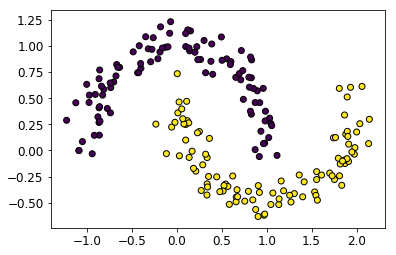

In [6]:
from sklearn import datasets

X, t = datasets.make_moons(n_samples = 200, noise = 0.1)
t = 2*t-1
plt.scatter(X[:,0], X[:,1], c=t, edgecolor='k')

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

## 4.2 Difference between linear and Gaussian kernels

First, we try linear SVM.

The number of iteration : 1780
Learning time : 1.0100035667419434 seconds


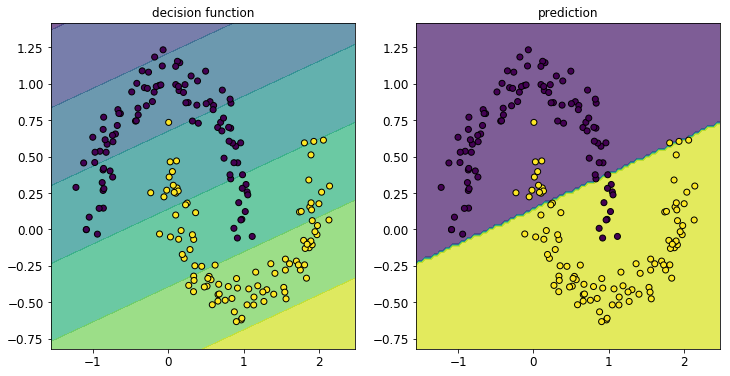

In [7]:
linkernel = LinearKernel()
linsvc = SVC(C=10.0, kernel=linkernel)
linsvc.fit(X, t, show_time=True)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,2,1)
ax.set_title("decision function")
plot_result(ax=ax, clf=linsvc, xx=xx, yy=yy, X=X, t=t, plot_decision_function=True)
ax = fig.add_subplot(1,2,2)
ax.set_title("prediction")
plot_result(ax=ax, clf=linsvc, xx=xx, yy=yy, X=X, t=t, plot_decision_function=False)

As can be anticipated easily, the decision boundary is linear, because we employed the linear kernel. 

Next, we try Gaussian kernel.

The number of iteration : 781
Learning time : 0.5375006198883057 seconds


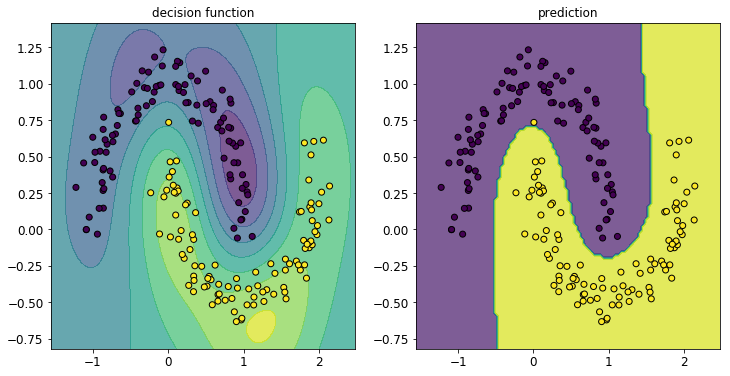

In [8]:
gkernel = GaussianKernel(theta=0.5)
gsvc = SVC(C=10.0, kernel=gkernel)
gsvc.fit(X, t, show_time=True)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,2,1)
ax.set_title("decision function")
plot_result(ax=ax, clf=gsvc, xx=xx, yy=yy, X=X, t=t, plot_decision_function=True)
ax = fig.add_subplot(1,2,2)
ax.set_title("prediction")
plot_result(ax=ax, clf=gsvc, xx=xx, yy=yy, X=X, t=t, plot_decision_function=False)

It can be seen that, thanks to kernel trick, we can handle such nonlinear decision boundary. 

## 4.3 Examining the sparsity

Let us examine how many support vectors we have, and visualize them. In the following plot, we plot support vectors as square.

In [9]:
len(linsvc.a)/len(X)

0.305

In [10]:
len(gsvc.a)/len(X)

0.075

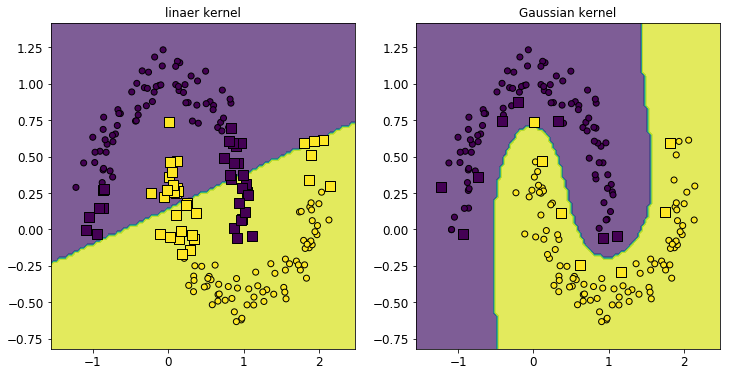

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title("linaer kernel")
plot_result(ax=ax, clf=linsvc, xx=xx, yy=yy, X=X, t=t, plot_decision_function=False, plot_sv=True)
ax = fig.add_subplot(122)
ax.set_title("Gaussian kernel")
plot_result(ax=ax, clf=gsvc, xx=xx, yy=yy, X=X, t=t, plot_decision_function=False, plot_sv=True)

We can see that the number of support vectors are much less than the number of training data, thus we can spare memory and computation speed for prediction.

## 4.4 The effect of hyperparameters

Let us take a look at how hyperparameters $C$ and $s$ affect the result.

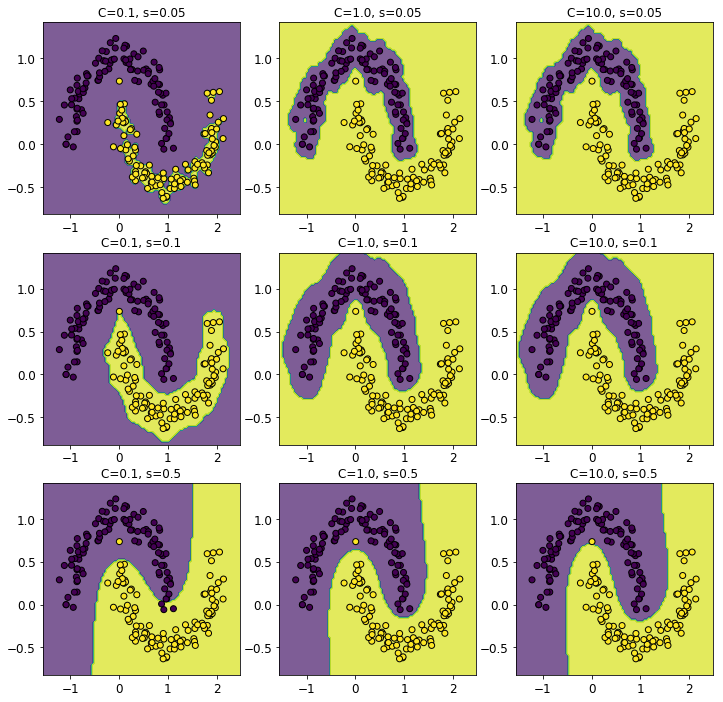

In [12]:
ss = [0.05, 0.1, 0.5]
CC = [0.1, 1.0, 10.0]

fig = plt.figure(figsize=(12,12))
for (cnts, s) in enumerate(ss):
    for (cntC, C) in enumerate(CC):
        gkernel = GaussianKernel(theta=s)
        svc = SVC(C=C, kernel=gkernel)
        svc.fit(X, t)
        ax = fig.add_subplot(len(ss), len(CC), cnts*len(CC)+cntC+1)
        plot_result(ax=ax, clf=svc, xx=xx, yy=yy, X=X, t=t)
        ax.set_title(f"C={C}, s={s}")
plt.show()

We can see that 
* increasing $s$ makes the decision boundary smoother, and that
* increasing $C$ penalizes misclassification more, resulting in less misclassification. 